In [ ]:
import pygame as pg
from pygame.locals import *
import cv2 as cv
import numpy as np
import sys
from matplotlib import pyplot as plt

import visio as v

In [ ]:
class Fitxa(pg.sprite.Sprite):
    def __init__(self,src,x,y,scale):
        pg.sprite.Sprite.__init__(self)
        self.scale = (20,40)
        self.src = 'src/fitxes/fitxa_{}.png'.format(src)
        self.scale = scale
        self.original_frame = pg.image.load(self.src)
        self.image = self.original_frame.copy().convert_alpha()
        #self.image.fill((255,127,0))
        self.image = pg.transform.scale(self.image,self.scale)
        self.rect = self.image.get_rect()
        self.rect.center = (self.rect.width/2,self.rect.height/2)
        self.rect.x = x
        self.rect.y = y
        
        # Propietats fitxa dins el joc
        self.drag = False
        self.placed=False
        self.angle = 0.0
        self.perpendicular = False
        self.rotate(45)
        
    def __str__(self):
        ret = str("{} :: {} ::{}".format(self.rect.center,self.drag,self.placed))
        return ret
    
    
    def hovered(self,x,y):
        if x in range(self.rect.left, self.rect.right) and y in range(self.rect.top, self.rect.bottom):
            return True
        else:
            return False
    def moveTo(self,x,y):
        self.rect.center = (x,y)
        
    def rotate(self, angle):
        self.angle = (self.angle+angle)%360
        old_center = self.rect.center
        self.image = self.original_frame.copy().convert_alpha()
        
        self.image = pg.transform.scale(self.image,self.scale)
        self.image = pg.transform.rotate(self.image,self.angle)
        self.rect = self.image.get_rect()
        self.rect.center = old_center

In [ ]:

FPS = 30

# [pygame] Inicialitzem el modul pygame 
pg.init()
# [pygame] Definim les característiques de la pantalla de joc
pg.display.set_caption("[Modul Control] Joc de domino en PyGame")
screen = pg.display.set_mode([800,600])
# [pygame] Registrem el primer frame per simular el video en directe
pg.image.save(screen,'frames/lastFrame.jpg')

'''
fitxaImg = pg.image.load('src/fitxa_66.png')
midaFitxes = (35,70)
'''

game_rotation = None
   
fitxes = pg.sprite.Group()
primerClick = False

spriteIndex = 0

# Bucle del joc
running = True
# [pygame] Pintem el fons 

background = pg.transform.scale(pg.image.load('src/tapete.png').convert(),(800,600))
while running:
    
    mx,my = pg.mouse.get_pos()
    
    

    # [openCV] Llegim la imatge de la partida
    frame = cv.imread('frames/lastFrame.jpg')
    
    estatPartida = v.processarFrame(frame)

    (posicio,midaFitxa,rotacio),template = v.getFirstFeatures(frame)
    
    
    
    cv.imshow("[Modul Visio] Estat de la partida processat amb OpenCV",v.mostrarResultat(frame,estatPartida))
    cv.imshow("[Modul Visio] CentreFitxa",template)
    
    
    #pg.time.wait(10)
    # [pygame i openCV] Detectem events
    for event in pg.event.get():
        if event.type == pg.QUIT:
            running=False
        if event.type == MOUSEMOTION:            
            for s in fitxes.sprites():
                if s.drag:
                    s.moveTo(mx,my)
                    break
                    
        if event.type == MOUSEBUTTONDOWN:
            if pg.mouse.get_pressed()[0]:
                if not primerClick:
                    fitxes.add(Fitxa(5,200,200,(50,100)))
                    primerClick=True
                else:
                    for s in fitxes.sprites():
                        if s.rect.collidepoint(mx,my):
                            if s.drag:
                                s.drag = False
                                if game_rotation is None:
                                    game_rotation = s.angle
                            else:
                                s.drag = True
                            break
                          
            elif pg.mouse.get_pressed()[2]:
                for s in fitxes.sprites():
                    if s.drag:
                        # TODO
                        #ANGLES DEPENENT DEL ESTAT DE LA PARTIDA
                        if game_rotation is None:
                            s.rotate(10)                            
                        else:
                            if not s.perpendicular:
                                s.rotate(game_rotation+90)
                                s.perpendicular = True
                            else:
                                s.rotate(90)
                        
        
    if cv.waitKey(1) == ord('q'):
        running=False
    
    
    # Update

 
    fitxes.update()

    # Draw/Render
    #screen.fill([17,119,17])
    screen.blit(background, [0, 0])
    fitxes.draw(screen)
    

    # [openCV] Cridem a la funcio del modul visio
    # TODO
    #
    
    # [openCV] Mostrem el joc 
    # TODO
    #
        

    # [pygame] Desem el frame de la partida
    pg.image.save(screen,'frames/lastFrame.jpg')
    

    
    # [pygame] Actualitzem la pantalla
    pg.display.update()
pg.quit()
cv.destroyAllWindows()

In [ ]:
import pygame,sys
import math
from pygame.locals import *
from random import randint
import visio as v
from matplotlib import pyplot as plt

## COLORS ##
white =(255,255,255)
black=(0,0,0)
red = (255,0,0)
green = (0,255,0)
greenTable=(17,119,17)
blue = (0,0,255)
orange = (255,153,0)

## WINDOW ##
heightW = 800
widthW = 1600
widthColumn = 600
heightRow = heightW/2

## TABLE ##
tableSide = 400 ## mm
laterals = 50 ##mm
areaList = []

## BASE
baseX= 1100
baseY= 600
baseHeight = 100 ##mm TODO ajustar
baseRadius = 50 ## mm

## Arm A
lenghtA = 250 ## mm
widthA = 25 ## mm
AposX = baseX+lenghtA
AposY = 400
degreeA = 0
maxDegreeA = 180

## Arm B
lenghtB = 250 ## mm
widthB = 25 ## mm
BposX = AposX+lenghtB
BposY = 400
degreeB = 90
maxDegreeB = 360 ## TODO ajustar

## Arm C
lengthC = 152 ##mm
maxDegreeC = 180
radiusC = 20 ##mm

autoRun = True



## FUNCTIONS ##

def drawTable():
    pygame.draw.rect(pWindow,greenTable,(baseX-round(tableSide/2),baseY-(tableSide + baseRadius), tableSide, tableSide))
    pygame.draw.rect(pWindow,orange,(baseX-round(tableSide/2)-laterals,baseY-(tableSide +baseRadius), laterals,tableSide))
    pygame.draw.rect(pWindow,orange,(baseX+round(tableSide/2),baseY-(tableSide +baseRadius), laterals,tableSide))
    

def calculateFirstArm():
    x = lenghtA * math.cos(math.radians(degreeA)) + baseX
    y = lenghtA * math.sin(math.radians(degreeA+180)) + baseY
    return x,y

def calculateSecondArm():
    x = lenghtB * math.cos(math.radians(degreeA - degreeB + 180))  + AposX
    y = lenghtB * math.sin(math.radians(degreeA - degreeB + 360)) + AposY
    return x,y

def printGrid():
    pWindow.fill(white)
    pygame.draw.line(pWindow, black, (widthColumn,0), (widthColumn, heightW))
    pygame.draw.line(pWindow, black, (0,heightRow), (widthColumn, heightRow))

def printFirstCell():
    pygame.draw.line(pWindow, blue, (0, 100),(400-(lenghtB*2),100), widthB)
    pygame.draw.line(pWindow, green, (400-(lenghtB*2),100), (400,100), widthB)

def printSecondCell():
    pygame.draw.line(pWindow, blue, (0, heightRow+(heightRow/2)),(400-(lenghtB*2),heightRow+(heightRow/2)), widthB)
    pygame.draw.line(pWindow, green, (400-(lenghtB*2),heightRow+(heightRow/2)), (400,heightRow+(heightRow/2)), widthB)

def calculateToolPath():
    pass
    ## 2*PI*radius ?


## MAIN ##

pygame.init()
pWindow= pygame.display.set_mode((widthW,heightW), pygame.RESIZABLE)
pygame.display.set_caption("R2-MINO")

v = v.VisionModule()


game_rotation = None    
fitxes = pg.sprite.Group()
primerClick = False
spriteIndex = 0

currentFrame = None




running = True
while running:
    mx,my = pg.mouse.get_pos()
    
    
    printGrid()
    drawTable()
    pygame.draw.circle(pWindow, red, (baseX,baseY), baseRadius)
    
    (AposX,AposY) = calculateFirstArm()
    pygame.draw.line(pWindow, blue, (baseX,baseY), (round(AposX),round(AposY)), widthA)

    (BposX,BposY) = calculateSecondArm()
    pygame.draw.line(pWindow, green, (round(AposX),round(AposY)), (round(BposX),round(BposY)), widthB)

    printFirstCell()
    pygame.draw.line(pWindow, orange, (350,50), (350,50+lengthC), widthB)

    printSecondCell()
    if currentFrame is None:
        pg.image.save(pWindow,'frames/lastFrame.jpg')
    
    currentFrame = cv.imread('frames/lastFrame.jpg')
    frame = currentFrame[100:550, 850:1350]
    
    # ROI 
    
    v.updateFrame(frame)
    v.processarFrame()
    
    
    
 
    cv.imshow("[Modul Visio] Estat de la partida processat amb OpenCV",v.background)
    
    
    
    for pEvent in pygame.event.get():
        if pEvent.type == QUIT:
            running = False
        ## MOUSE controls
        if pEvent.type == MOUSEMOTION:            
            for s in fitxes.sprites():
                if s.drag:
                    s.moveTo(mx,my)
                    break
                    
        if pEvent.type == MOUSEBUTTONDOWN:
            if pg.mouse.get_pressed()[0]:
                if not primerClick:
                                     
                    
                    fitxes.add(Fitxa(5,200,200,(20,40)))
                    primerClick=True
                else:
                    for s in fitxes.sprites():
                        if s.rect.collidepoint(mx,my):
                            if s.drag:
                                s.drag = False
                                if game_rotation is None:
                                    game_rotation = s.angle
                            else:
                                s.drag = True
                            break
                          
            elif pg.mouse.get_pressed()[2]:
                for s in fitxes.sprites():
                    if s.drag:
                        # TODO
                        #ANGLES DEPENENT DEL ESTAT DE LA PARTIDA
                        if game_rotation is None:
                            s.rotate(10)                            
                        else:
                            if not s.perpendicular:
                                s.rotate(game_rotation+90)
                                s.perpendicular = True
                            else:
                                s.rotate(90)        
        
        ## KEY controls
        elif pEvent.type == pygame.KEYDOWN:
            if pEvent.key == K_LEFT:
                if degreeA<maxDegreeA:
                    degreeA+=1
            elif pEvent.key == K_RIGHT:
                if degreeA>0:
                   degreeA-=1
            if pEvent.key == K_UP:
                if degreeB<maxDegreeB:
                    degreeB+=1
            elif pEvent.key == K_DOWN:
                if degreeB>0:
                    degreeB-=1
        ## END KEY controls

    if(autoRun == True):
        degreeB+=1
        if degreeB > maxDegreeB:
            degreeB = 0
            degreeA += 1
            if degreeA > maxDegreeA:
                degreeA = 0
        
    fitxes.update()
    fitxes.draw(pWindow)
    pygame.display.update()
    pygame.image.save(pWindow,'frames/lastFrame.jpg')
    
pg.quit()
cv.destroyAllWindows()

In [ ]:
import pygame,sys
import math
import time
from pygame.locals import *
from random import randint
from moviment import C

## COLORS ##
white =(255,255,255)
black=(0,0,0)
red = (255,0,0)
green = (0,255,0)
greenTable=(17,119,17)
blue = (0,0,255)
orange = (255,153,0)

## WINDOW ##
heightW = 800
widthW = 1600
widthColumn = 600
heightRow = round(heightW/2)

## TABLE ##
tableSide = 400 ## mm
laterals = 100 ##mm

## BASE
baseX= 1100
baseY= 600
baseRadius = 50 ## mm

## Arm A
lenghtA = 275 ## mm
widthA = 25 ## mm
AposX = baseX + lenghtA
AposY = 400
degreeA = 0
maxDegreeA = 360

## Arm B
lenghtB = 275 ## mm
widthB = 25 ## mm
BposX = AposX + lenghtB
BposY = 400
degreeB = 0
maxDegreeB = 360 ## 

## Arm C
lengthC = 200 ##mm
maxHeight = 60
minHeight = 140
actualHeight = maxHeight
isDown = False

## Tool
minOpening = 20
maxOpening = 40
actualOpening = maxOpening
degreeTool = 180
nextDegreeTool = degreeTool
maxDegreeTool = 360
toolCompensation = 0


## INIT ##

pygame.init()
m = C()
pWindow= pygame.display.set_mode((widthW,heightW), pygame.RESIZABLE)
pygame.display.set_caption("R2-MINO")
degreeA, degreeB = m.idlePosition()
next_degreeA = degreeA
next_degreeB = degreeB
next_toolCompensation = toolCompensation
armAReady = False
armBReady = False
compensationReady = False

hasStartedCatch = False
hasStartedDrop = False

count_test1 = 0
count_test2 = 0
count_test3 = 0
count_test4 = 0
setIdle = False


## CALCULATE FUNCTIONS ##

def calculateFirstArm():
    x = lenghtA * math.cos(math.radians(degreeA)) + baseX
    y = lenghtA * math.sin(math.radians(degreeA+180)) + baseY
    return x,y

def calculateSecondArm():
    x = lenghtB * math.cos(math.radians(degreeA + degreeB + 180))  + AposX
    y = lenghtB * math.sin(math.radians(degreeA + degreeB + 360)) + AposY
    return x,y

def calculateSlide(degA, degB):
    x = math.cos(math.radians(degA))* math.sin(math.radians(degB)) + math.sin(math.radians(degA))* math.cos(math.radians(degB))
    y = math.sin(math.radians(degA))* math.sin(math.radians(degB)) - math.cos(math.radians(degA))* math.cos(math.radians(degB))
    deg = math.degrees(math.atan2(y, x))
    print(deg)

def calculateSecondArmAngle():
    x = round(BposX) - round(AposX)
    y = round(BposY) - round(AposY)
    degree =  math.degrees(math.atan2(y, x))
    return degree

def calculateToolAngleForPrint():
    return degreeTool + calculateSecondArmAngle()

def calculateIdleDegreeTool():
    x = round(BposX) - round(AposX)
    y = round(BposY) - round(AposY)
    degree = math.degrees(math.atan2(y, x))
    return degree + degreeTool


## PRINT FUNCTIONS ##
PURPLE = (83, 33, 158)

def drawEllipse(x, y):
    pygame.draw.ellipse(pWindow, PURPLE, [x, y-100, tableSide, 200])
    

def drawTable():
    drawEllipse(baseX-round(tableSide/2), baseY-(tableSide + baseRadius))
    pygame.draw.rect(pWindow,greenTable,(baseX-round(tableSide/2),baseY-(tableSide + baseRadius), tableSide, tableSide))
    pygame.draw.rect(pWindow,orange,(baseX-round(tableSide/2)-laterals,baseY-(tableSide +baseRadius), laterals,tableSide))
    pygame.draw.rect(pWindow,orange,(baseX+round(tableSide/2),baseY-(tableSide +baseRadius), laterals,tableSide))
    


def printGrid():
    pWindow.fill(white)
    pygame.draw.line(pWindow, black, (widthColumn,0), (widthColumn, heightW))
    pygame.draw.line(pWindow, black, (0,heightRow), (widthColumn, heightRow))

def printFirstCell():
    pygame.draw.line(pWindow, green, (0,round(heightRow/2)), (375,round(heightRow/2)), widthB)

def printSecondCell():
    pygame.draw.line(pWindow, green, (widthColumn/2,heightW), (widthColumn/2,heightRow+round(heightRow/2)), widthB)

def printLiftTool(actualHeight):
    pygame.draw.line(pWindow, orange, (350,actualHeight+20), (350,actualHeight+lengthC), widthB)

def printTool(actualHeight, actualOpening):
    pygame.draw.line(pWindow, red, (350,actualHeight+lengthC), (350+actualOpening,actualHeight+lengthC+50), 15)
    pygame.draw.line(pWindow, blue, (350,actualHeight+lengthC), (350-actualOpening,actualHeight+lengthC+50), 15)

def printToolCell2(degree):
    centerX = widthColumn/2
    centerY = round(heightRow+(heightRow/2))
    lenghtTool = 50
    blueX = lenghtTool * math.cos(math.radians(degree+180)) + centerX
    blueY = lenghtTool * math.sin(math.radians(degree+180)) + lengthC + heightRow
    redX = lenghtTool * math.cos(math.radians(degree)) + centerX
    redY =  lenghtTool * math.sin(math.radians(degree)) + lengthC + heightRow
    pygame.draw.line(pWindow, blue, (round(blueX),round(blueY)), (centerX,centerY), 15)
    pygame.draw.line(pWindow, red, (round(redX),round(redY)), (centerX,centerY), 15)

##def printToolPrincipal(degree):
##    centerX, centerY = calculateSecondArm()
##    
##    lenghtTool = 50
##    blueX = lenghtTool * math.cos(math.radians(calculateToolAngleForPrint()+90)) + centerX
##    blueY = lenghtTool * math.sin(math.radians(calculateToolAngleForPrint()+90)) + centerY
##    redX = lenghtTool * math.cos(math.radians(calculateToolAngleForPrint()-90)) + centerX
##    redY =  lenghtTool * math.sin(math.radians(calculateToolAngleForPrint()-90)) + centerY
##    pygame.draw.line(pWindow, blue, (round(blueX),round(blueY)), (centerX,centerY), 15)
##    pygame.draw.line(pWindow, red, (round(redX),round(redY)), (centerX,centerY), 15)
    
def printRutine():
    global AposX, AposY, BposX, BposY
    printGrid()
    drawTable()
    pygame.draw.circle(pWindow, red, (baseX,baseY), baseRadius)
    
    (AposX,AposY) = calculateFirstArm()
    pygame.draw.line(pWindow, blue, (baseX,baseY), (round(AposX),round(AposY)), widthA)

    (BposX,BposY) = calculateSecondArm()
    pygame.draw.line(pWindow, green, (round(AposX),round(AposY)), (round(BposX),round(BposY)), widthB)

    #printToolPrincipal(calculateIdleDegreeTool())

    printFirstCell()
    printLiftTool(actualHeight)
    printTool(actualHeight, actualOpening)
    
    printSecondCell()
    printToolCell2(degreeTool)
    calculateSecondArmAngle()

    
 
## MOVEMENT FUNCTIONS ##

def goTo(goX, goY, isDegree):
    global next_degreeA
    global next_degreeB
    global degreeA
    global degreeB

    armAReady = False
    armBReady = False

    if isDegree:
        next_degreeA, next_degreeB = goX, goY
    else: 
        next_degreeA, next_degreeB = m.calculate_movement(goX, goY)

    while (not armAReady or not armBReady):
        printRutine()

        ## Gradual increment of degreeA
        if round(degreeA,2) != next_degreeA:
            if(degreeA < next_degreeA):
                degreeA +=0.01

            else:
                degreeA -=0.01
        else:
            armAReady = True

        ## Gradual increment of degreeB
        if round(degreeB,2) != next_degreeB:
            if(degreeB < next_degreeB):
                degreeB +=0.01
            else:
                degreeB -=0.01
        else:
            armBReady = True
        
        pygame.display.update()

def openTool(): 
    global actualOpening
    
    while True:
        printRutine()
        if(actualOpening < m.operateToolOpen(True)):
            actualOpening +=0.05
        else:
            pygame.display.update()
            break
        pygame.display.update()
        
def closeTool(): 
    global actualOpening

    while True:
        printRutine()
        if(actualOpening > m.operateToolOpen(False)):
            actualOpening -=0.05
        else:
            pygame.display.update()
            break
        pygame.display.update()

def upTool():
    global actualHeight

    while True:
        printRutine()
        if(actualHeight > operateToolLift(True)):
            actualHeight -=0.05
        else:
            pygame.display.update()
            break
        pygame.display.update()

def downTool():
    global actualHeight

    while True:
        printRutine()
        if(actualHeight < operateToolLift(False)):
            actualHeight +=0.05
        else:
            pygame.display.update()
            break
        pygame.display.update()

def rotateTool(orientation):
    global degreeTool
    next_degreeTool = m.operateToolRotate(orientation)
    
    while True:
        printRutine()
        if round(degreeTool,2) != round(next_degreeTool,2):
            if(degreeTool < next_degreeTool):
                degreeTool +=0.05
            else:
                degreeTool -=0.05
        else:
            pygame.display.update()
            break   
        pygame.display.update()
        
def goIdle():
    x, y = m.idlePosition()
    goTo(x, y, True)

def goSignalPlayer(player):
    x, y = m.signalPlayer(player)
    goTo(x, y, True)
    closeTool()
    openTool()
    closeTool()
    openTool()    
    
def catch(pX, pY, orientation):
    goTo(pX, pY, False)
    rotateTool(orientation)
    downTool()
    closeTool()
    upTool()

def drop(pX, pY, orientation):
    goTo(pX, pY, False)
    rotateTool(orientation)
    downTool()
    openTool()
    upTool()

def dance():
    goTo(0, 20, False)
    goTo(5, 25, False)
    goTo(0, 30, False)
    closeTool()
    openTool()
    goTo(-5, 25, False)
    goTo(0, 20, False)
    closeTool()
    openTool()
    closeTool()
    openTool()
    goTo(-5, 25, False)
    goTo(0, 30, False)
    closeTool()
    openTool()
    goTo(5, 25, False)
    goTo(0, 20, False)
    closeTool()
    openTool()
    closeTool()
    openTool()

def signalPass():
    goIdle()
    rotateTool('N')
    rotateTool('S')
    rotateTool('N')
    rotateTool('S')
    
## TESTS ##
def test1():
    positions = [[0, 5], [25, 5], [25, 25], [25, 45], [0, 45], [-20, 45], [-20, 25], [-20, 5]]
    (x, y) = mov.calculate_movement(positions[count_test1][0], positions[count_test1][1])
    return x, y

def test2(setIdle):
    positions = [[10, 15], [10, 35], [-10, 35], [-10, 15], [0, 25]]
    if setIdle == True:
        (x, y) = resetDegrees()
    else:
        (x, y) = mov.calculate_movement(positions[count_test2][0], positions[count_test2][1])
    
    return x, y

def test3 ():
    global hasStartedCatch
    global hasStartedDrop
    if(count_test3 == 0):
        goTo(-22,44, False)
        hasStartedCatch = True
    elif(count_test3 == 1):
        goTo(10,35, False)
        hasStartedDrop = True
    elif(count_test3 == 2):
        goTo(10,35, True)

def test4():
    global nextDegreeTool
    positions = ["N", "N", "N", "N", "N", "N", "N"]
    nextDegreeTool = mov.operateToolRotate(positions[count_test4], degreeA, degreeB, degreeTool)
    print("A: ", degreeA, " B: ", degreeB, " C: ", degreeTool)
    print("New degree: ",nextDegreeTool)
    

def wtf():
    baseX = lenghtA * math.cos(math.radians(degreeA))
    baseY = lenghtA * math.sin(math.radians(degreeB+180))

    toolX = lenghtB * math.cos(math.radians(degreeA + degreeB + 180))  + baseX
    toolY = lenghtB * math.sin(math.radians(degreeA + degreeB + 360)) + baseY

    x = round(toolX) - round(baseX)
    y = round(toolY) - round(baseY)
    degree =  math.degrees(math.atan2(y, x))
    print("degreeC: ", degreeTool, " degreeB: ", degree)
    

## MAIN ##
fitxes = pygame.sprite.Group()
primerClick = False
spriteIndex = 0
game_rotation = None
running = True
vis = v.Visio()
estatPartida = None
while running:
    printRutine()
    #wtf()
    mx,my = pygame.mouse.get_pos()
    # [openCV] Llegim la imatge de la partida
    frame = cv.imread('frames/lastFrame.jpg')
    x0 = 800
    y0 = 50
    w0 = 600
    h0 = 550
    cropFrame = frame[y0:y0+h0,x0:x0+w0]
    vis.updateFrame(cropFrame)
    cv.imwrite('cropFrame.jpg',cropFrame)
    cv.imshow('[ModulVisio]',vis.showFrame())
    for pEvent in pygame.event.get():
        if pEvent.type == QUIT:
            running=False
            
        ## KEY controls
        elif pEvent.type == pygame.KEYDOWN:

            # Test 2: movement + idle
            if pEvent.key == K_LEFT:
                catch(0, 25, "N")
                drop(-25, 25, "S")
                #dance()
        if pEvent.type == MOUSEMOTION:            
            for s in fitxes.sprites():
                if s.drag:
                    s.moveTo(mx,my)
                    break
                    
        if pEvent.type == MOUSEBUTTONDOWN:
            if pygame.mouse.get_pressed()[0]:
                if not primerClick:
                    fitxes.add(Fitxa(5,900,200,(40,80)))
                    primerClick=True
                else:
                    for s in fitxes.sprites():
                        if s.rect.collidepoint(mx,my):
                            if s.drag:
                                s.drag = False
                                if game_rotation is None:
                                    game_rotation = s.angle
                            else:
                                s.drag = True
                            break
                          
            elif pygame.mouse.get_pressed()[2]:
                for s in fitxes.sprites():
                    if s.drag:
                        # TODO
                        #ANGLES DEPENENT DEL ESTAT DE LA PARTIDA
                        if game_rotation is None:
                            s.rotate(10)                            
                        else:
                            if not s.perpendicular:
                                s.rotate(game_rotation+90)
                                s.perpendicular = True
                            else:
                                s.rotate(90)     
    if cv.waitKey(1) == ord('q'):
        running=False
    
    fitxes.update()
    fitxes.draw(pWindow)
    pygame.display.update()
    pygame.image.save(pWindow,'frames/lastFrame.jpg')
    
pygame.quit()
##    for pEvent in pygame.event.get():
##        if pEvent.type == QUIT:
##            pygame.quit()
##            sys.exit()
##        ## KEY controls
##        elif pEvent.type == pygame.KEYDOWN:
##
##            # Test 2: movement + idle
##            if pEvent.key == K_LEFT:
##                next_degreeA, next_degreeB = test2(setIdle)
##                hasStartedCatch = False
##                hasStartedDrop = False
##                if setIdle:
##                    setIdle = False
##                else:
##                    count_test2 +=1
##                    setIdle = True 
##                if count_test2>4:
##                    count_test2 = 0
##                    
##            # Test 1: movement
##            elif pEvent.key == K_RIGHT:
##                next_degreeA, next_degreeB = test1()
##                calculateSlide(next_degreeA, next_degreeB)
##                count_test1 +=1
##                if count_test1>7:
##                    count_test1 = 0
##
##            # Test 3: catch + drop        
##            if pEvent.key == K_UP:
##                test3()
##                count_test3 +=1
##                if count_test3>2:
##                    count_test3 = 0
##
##            # Test 4: tool
##            elif pEvent.key == K_DOWN:
##                test4()
##                count_test4 +=1
##                if count_test4>6:
##                    count_test4 = 0
##        ## END KEY controls
##
##
##    ## Gradual increment of degreeA
##    if round(degreeA,2) != next_degreeA:
##        armAReady = False
##        if(degreeA < next_degreeA):
##            degreeA +=0.01
##        else:
##            degreeA -=0.01
##    else:
##        armAReady = True
##
##    ## Gradual increment of degreeB
##    if round(degreeB,2) != next_degreeB:
##        armBReady = False
##        if(degreeB < next_degreeB):
##            degreeB +=0.01
##        else:
##            degreeB -=0.01
##    else:
##        armBReady = True
##
##    ## Gradual increment of compensationTool
##    if round(degreeTool,2) != round(nextDegreeTool,2):
## 
##        if(degreeTool < nextDegreeTool):
##            degreeTool +=0.05
##        else:
##            degreeTool -=0.05
##   
##
##    ## Flow control
##    if armAReady and armBReady and hasStartedCatch:
##        catch()
##    if armAReady and armBReady and hasStartedDrop:
##        drop()
##
##    ## Window update
##    pygame.display.update()

    


In [ ]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import visio as v

vis = v.Visio()

bg = cv.imread('cropFrame.jpg')
vis.updateFrame(bg)
frame = cv.imread('cropFrame2.jpg')
vis.updateFrame(frame)
      
bg = cv.cvtColor(cv.imread('cropFrame.jpg'),cv.COLOR_BGR2GRAY)
frame = cv.cvtColor(cv.imread('cropFrame2.jpg'),cv.COLOR_BGR2GRAY)
      
thr = 0.25
out = np.subtract(frame,bg)

mask = abs(out)>thr

mask = cv.dilate(out, np.ones((1,1), np.uint8), iterations=1)
mask = cv.erode(mask, np.ones((2,2), np.uint8), iterations=1)  
mask[mask>0]=1

frame=frame*mask

vis.grayFrame = frame
print('dsfsdf {}'.format(vis.getTableData()))
plt.figure()
plt.imshow(vis.grayFrame,'gray')

-90.0


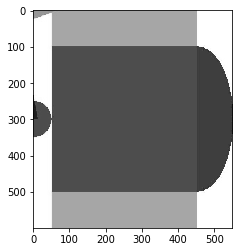

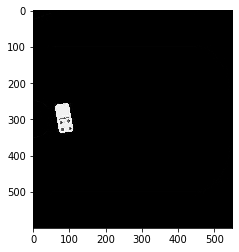

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import visio as v

vis = v.Visio()

bg = cv.imread('cropFrame.jpg')
vis.updateFrame(bg)
plt.figure()
plt.imshow(vis.rotatedFrame,'gray')

frame = cv.imread('cropFrame2.jpg')
vis.updateFrame(frame)
print(vis.rotacioDefecte)
plt.figure()
plt.imshow(vis.rotatedFrame,'gray')